# 3. Model Training and Evaluation

## Objective
Split data into train/test sets, build and train baseline MLP, apply regularization techniques, evaluate all models, and save the best model.

### Input
- `data/processed/2_featured_data.csv`

### Output
- `models/best_mlp_model.h5`
- Performance metrics and plots

---

In [28]:
# ==============================================================================
# SETUP CELL: Environment and Imports
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Set project root directory for robust path handling
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'models')

# Ensure directories exist
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported and environment set successfully.")
print(f"Project Root: {PROJECT_ROOT}")

Libraries imported and environment set successfully.
Project Root: /home/ghost/workspace/university/machine_learning_and_computer_vision/assessment_main


## Step 1: Load Preprocessed Data and Preprocessor

We load the preprocessed train/test data arrays from `3_final_data.npz` and the fitted preprocessor object that was saved during feature engineering. This ensures consistency in data preprocessing between training and future inference.

In [29]:
# Load preprocessed data arrays
data_path = os.path.join(PROCESSED_DATA_DIR, "3_final_data_resampled.npz")
loaded_data = np.load(data_path)

# Unpack the arrays (training data is SMOTE-resampled, test data is original)
X_train = loaded_data["X_train"]  # SMOTE-resampled training features
X_test = loaded_data["X_test"]    # Original test features
y_train = loaded_data["y_train"]  # SMOTE-resampled training labels
y_test = loaded_data["y_test"]    # Original test labels

# Load the fitted preprocessor
preprocessor_path = os.path.join(MODELS_DIR, "preprocessor.joblib")
preprocessor = joblib.load(preprocessor_path)

# Print shapes to confirm successful loading
print("Data loaded successfully!")
print("="*70)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]} (SMOTE-resampled)")
print(f"Test samples: {X_test.shape[0]} (original distribution)")
print("="*70)

Data loaded successfully!
X_train shape: (144648, 2290)
X_test shape: (20353, 2290)
y_train shape: (144648,)
y_test shape: (20353,)
Number of features: 2290
Training samples: 144648 (SMOTE-resampled)
Test samples: 20353 (original distribution)


### Edge Case Checks

Before proceeding with model training, we perform critical edge case checks as outlined in the edge case handling guide.

In [30]:
# Edge Case EC1: Check for GPU availability (for training speed)
print("GPU Availability Check:")
print("="*70)
try:
    from tensorflow.python.client import device_lib
    devices = device_lib.list_local_devices()
    gpu_available = any(device.device_type == "GPU" for device in devices)

    if gpu_available:
        print("✓ GPU detected! Training will be faster.")
        for device in devices:
            if device.device_type == "GPU":
                print(f"  Device: {device.name}")
    else:
        print("⚠ No GPU detected. Training will use CPU (slower but functional).")
        print("  Consider using a smaller batch size (32-64) for CPU training.")
except Exception as e:
    print(f"⚠ Could not check GPU status: {e}")
    print("  Proceeding with default configuration.")

print("="*70)

# Edge Case EC3: Verify data shapes match expected dimensions
print("Data Shape Validation:")
print("="*70)
assert X_train.shape[1] == X_test.shape[1], "Feature mismatch between train and test sets!"
assert len(y_train) == X_train.shape[0], "Target length mismatch in training set!"
assert len(y_test) == X_test.shape[0], "Target length mismatch in test set!"

print(f"✓ Data shapes are consistent")
print(f"✓ Number of features: {X_train.shape[1]}")
print(f"✓ Training samples: {X_train.shape[0]} (SMOTE-resampled)")
print(f"✓ Test samples: {X_test.shape[0]} (original distribution)")

# Edge Case EC2: Check class distribution
print("Class Distribution Check:")
print("="*70)
print("Training Set (Should be balanced after SMOTE):")
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_dist_train = dict(zip(unique_train, counts_train))
print(f"  Class 0 (No Readmission): {class_dist_train.get(0, 0)} ({class_dist_train.get(0, 0)/len(y_train)*100:.1f}%)")
print(f"  Class 1 (Readmission): {class_dist_train.get(1, 0)} ({class_dist_train.get(1, 0)/len(y_train)*100:.1f}%)")

print("Test Set (Original distribution - for unbiased evaluation):")
unique_test, counts_test = np.unique(y_test, return_counts=True)
class_dist_test = dict(zip(unique_test, counts_test))
print(f"  Class 0 (No Readmission): {class_dist_test.get(0, 0)} ({class_dist_test.get(0, 0)/len(y_test)*100:.1f}%)")
print(f"  Class 1 (Readmission): {class_dist_test.get(1, 0)} ({class_dist_test.get(1, 0)/len(y_test)*100:.1f}%)")

if class_dist_train.get(1, 0) / len(y_train) < 0.4:
    print("⚠ WARNING: Training set still shows imbalance - SMOTE may not have been applied!")
else:
    print("✓ Training set is balanced (SMOTE applied successfully)")
print("="*70)

GPU Availability Check:
⚠ No GPU detected. Training will use CPU (slower but functional).
  Consider using a smaller batch size (32-64) for CPU training.
Data Shape Validation:
✓ Data shapes are consistent
✓ Number of features: 2290
✓ Training samples: 144648 (SMOTE-resampled)
✓ Test samples: 20353 (original distribution)
Class Distribution Check:
Training Set (Should be balanced after SMOTE):
  Class 0 (No Readmission): 72324 (50.0%)
  Class 1 (Readmission): 72324 (50.0%)
Test Set (Original distribution - for unbiased evaluation):
  Class 0 (No Readmission): 18082 (88.8%)
  Class 1 (Readmission): 2271 (11.2%)
✓ Training set is balanced (SMOTE applied successfully)


E0000 00:00:1762797079.959966 1487841 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762797079.960141 1487841 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Step 2: Build the Baseline MLP Model

### Baseline Model Architecture

We build a baseline Multiple Layer Perceptron (MLP) with the following architecture:

- **Input Layer**: Dense layer with 128 neurons, ReLU activation
- **Hidden Layer**: Dense layer with 64 neurons, ReLU activation  
- **Output Layer**: Dense layer with 1 neuron, Sigmoid activation (for binary classification)

**Architecture Justification**:
- **128-64-1 structure**: This creates a funnel architecture that progressively compresses information from features to prediction
- **ReLU activation**: Prevents vanishing gradients and allows for faster training compared to sigmoid/tanh
- **Sigmoid output**: Outputs a probability between 0-1 for binary classification
- **Adam optimizer**: Adaptive learning rate optimizer that works well for most problems
- **Binary crossentropy loss**: Standard loss function for binary classification tasks

In [31]:
# Clear any previous models from memory
tf.keras.backend.clear_session()

# Get the number of input features
input_dim = X_train.shape[1]

# Build the baseline model
baseline_model = Sequential(
    [
        Dense(128, activation="relu", input_dim=input_dim),
        Dense(64, activation="relu"),
        # Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ],
    name="baseline_model",
)

# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','precision','recall']
)

# Print model summary
print("Baseline Model Architecture:")
print("="*70)
baseline_model.summary()
print("="*70)

Baseline Model Architecture:


Model: "baseline_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       293,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,569 (1.15 MB)

 Trainable params: 301,569 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

## Step 3: Train and Evaluate the Baseline Model

We train the baseline model for 50 epochs with a batch size of 32, using the test set as validation data to monitor performance on unseen data.

In [32]:
# Train the baseline model
print("Training Baseline Model...")
print("="*70)

history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

print("="*70)
print("Training completed!")

Training Baseline Model...
Epoch 1/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.7706 - loss: 0.4678 - precision: 0.7618 - recall: 0.7873 - val_accuracy: 0.7307 - val_loss: 0.5986 - val_precision: 0.1639 - val_recall: 0.3448
Epoch 2/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9050 - loss: 0.2309 - precision: 0.9048 - recall: 0.9052 - val_accuracy: 0.7585 - val_loss: 0.6537 - val_precision: 0.1678 - val_recall: 0.2941
Epoch 3/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9358 - loss: 0.1604 - precision: 0.9393 - recall: 0.9318 - val_accuracy: 0.8044 - val_loss: 0.6528 - val_precision: 0.1833 - val_recall: 0.2180
Epoch 4/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9508 - loss: 0.1254 - precision: 0.9559 - recall: 0.9452 - val_accuracy: 0.8218 - val_loss: 0.7168 - val_precision: 0.1884 - val_recall: 0.1805
Epoch 5/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9602 - loss: 0.1020 - precision: 0.9645 - recal

### Baseline Model Evaluation

We evaluate the baseline model using classification metrics and visualizations.

In [33]:
# Make predictions on test set
y_pred_proba_baseline = baseline_model.predict(X_test)
y_pred_class_baseline = (y_pred_proba_baseline > 0.5).astype(int).flatten()

# Calculate metrics
print("Baseline Model Performance Metrics:")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_baseline, target_names=['No Readmission', 'Readmission']))

print("\nConfusion Matrix:")
cm_baseline = confusion_matrix(y_test, y_pred_class_baseline)
print(cm_baseline)

roc_auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)
print(f"\nROC AUC Score: {roc_auc_baseline:.4f}")
print("="*70)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Baseline Model Performance Metrics:

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      0.91      0.90     18082
   Readmission       0.17      0.14      0.16      2271

      accuracy                           0.83     20353
     macro avg       0.53      0.53      0.53     20353
  weighted avg       0.81      0.83      0.82     20353


Confusion Matrix:
[[16508  1574]
 [ 1942   329]]

ROC AUC Score: 0.5702


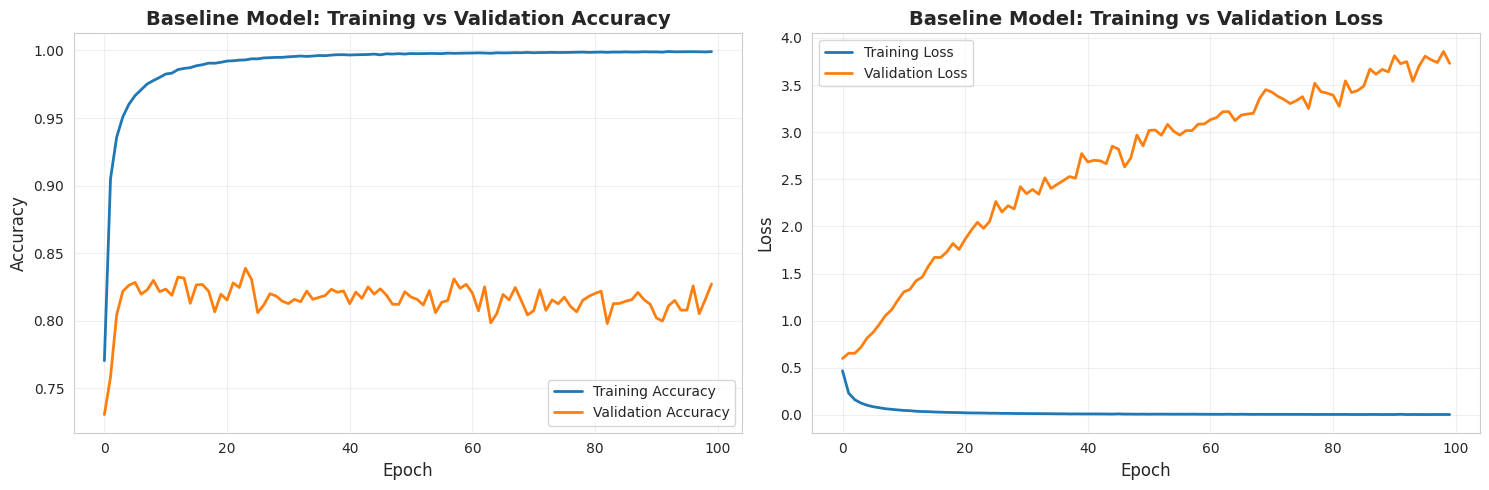


Final Training Accuracy: 0.9991
Final Validation Accuracy: 0.8272
Gap (Overfitting indicator): 0.1718


In [34]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Baseline Model: Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history_baseline.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_baseline.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Baseline Model: Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/model_training/baseline_model_training_history.png", dpi=300)
plt.show()

# Check for overfitting
train_acc = history_baseline.history['accuracy'][-1]
val_acc = history_baseline.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Gap (Overfitting indicator): {abs(train_acc - val_acc):.4f}")

## Step 4: Apply Regularization Techniques

We now build and train three additional models, each using a different regularization technique to improve upon the baseline and reduce overfitting.

### 4a. Model with Dropout

Dropout randomly drops a percentage of neurons during training, forcing the network to learn redundant representations and preventing over-reliance on specific features. We use a dropout rate of 0.3 (30%).

In [35]:
# Build model with Dropout
dropout_model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
], name='dropout_model')

# Compile the model
dropout_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", "precision", "recall"],
)

print("Dropout Model Architecture:")
print("="*70)
dropout_model.summary()
print("="*70)

# Train the model
print("\nTraining Dropout Model...")
history_dropout = dropout_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)
print("Training completed!")

Dropout Model Architecture:


Model: "dropout_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       293,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,569 (1.15 MB)

 Trainable params: 301,569 (1.15 MB)

 Non-trainable params: 0 (0.00 B)


Training Dropout Model...
Epoch 1/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.7207 - loss: 0.5414 - precision: 0.7107 - recall: 0.7446 - val_accuracy: 0.7818 - val_loss: 0.4837 - val_precision: 0.1899 - val_recall: 0.2928
Epoch 2/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.8459 - loss: 0.3540 - precision: 0.8397 - recall: 0.8549 - val_accuracy: 0.8063 - val_loss: 0.4819 - val_precision: 0.2034 - val_recall: 0.2523
Epoch 3/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.8822 - loss: 0.2805 - precision: 0.8820 - recall: 0.8824 - val_accuracy: 0.8358 - val_loss: 0.4825 - val_precision: 0.2209 - val_recall: 0.1867
Epoch 4/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9006 - loss: 0.2404 - precision: 0.9017 - recall: 0.8992 - val_accuracy: 0.8395 - val_loss: 0.5058 - val_precision: 0.2231 - val_recall: 0.1766
Epoch 5/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9122 - loss: 0.2148 - precision: 0.9125 - recal

#### Evaluate Dropout Model

Compare the Dropout model's performance to the baseline to assess the impact of dropout regularization.

In [36]:
# Make predictions
y_pred_proba_dropout = dropout_model.predict(X_test)
y_pred_class_dropout = (y_pred_proba_dropout > 0.5).astype(int).flatten()

# Calculate metrics
print("Dropout Model Performance Metrics:")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_dropout, target_names=['No Readmission', 'Readmission']))

print("\nConfusion Matrix:")
cm_dropout = confusion_matrix(y_test, y_pred_class_dropout)
print(cm_dropout)

roc_auc_dropout = roc_auc_score(y_test, y_pred_proba_dropout)
print(f"\nROC AUC Score: {roc_auc_dropout:.4f}")

# Compare to baseline
print(f"\nComparison to Baseline:")
print(f"  Baseline ROC AUC: {roc_auc_baseline:.4f}")
print(f"  Dropout ROC AUC:  {roc_auc_dropout:.4f}")
print(f"  Improvement:      {roc_auc_dropout - roc_auc_baseline:+.4f}")
print("="*70)

637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Dropout Model Performance Metrics:

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      0.97      0.93     18082
   Readmission       0.21      0.06      0.09      2271

      accuracy                           0.87     20353
     macro avg       0.55      0.52      0.51     20353
  weighted avg       0.82      0.87      0.84     20353


Confusion Matrix:
[[17599   483]
 [ 2141   130]]

ROC AUC Score: 0.5761

Comparison to Baseline:
  Baseline ROC AUC: 0.5702
  Dropout ROC AUC:  0.5761
  Improvement:      +0.0059


### 4b. Model with Batch Normalization

Batch Normalization normalizes layer inputs during training, which can speed up training and act as a form of regularization. We add BatchNormalization layers after each Dense layer before activation.

In [37]:
# Build model with Batch Normalization
# Pattern: Dense -> BatchNorm -> Activation
batchnorm_model = Sequential([
    Dense(128, input_dim=input_dim),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    Dense(64),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    Dense(1, activation='sigmoid')
], name='batchnorm_model')

# Compile the model
batchnorm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", "precision", "recall"],
)

print("Batch Normalization Model Architecture:")
print("="*70)
batchnorm_model.summary()
print("="*70)

# Train the model
print("\nTraining Batch Normalization Model...")
history_batchnorm = batchnorm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)
print("Training completed!")

Batch Normalization Model Architecture:


Model: "batchnorm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │       293,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,337 (1.15 MB)

 Trainable params: 301,953 (1.15 MB)

 Non-trainable params: 384 (1.50 KB)


Training Batch Normalization Model...
Epoch 1/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.7593 - loss: 0.4898 - precision: 0.7538 - recall: 0.7700 - val_accuracy: 0.8007 - val_loss: 0.4835 - val_precision: 0.1883 - val_recall: 0.2373
Epoch 2/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8790 - loss: 0.2846 - precision: 0.8797 - recall: 0.8780 - val_accuracy: 0.8201 - val_loss: 0.5286 - val_precision: 0.1944 - val_recall: 0.1946
Epoch 3/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9190 - loss: 0.2005 - precision: 0.9222 - recall: 0.9152 - val_accuracy: 0.8287 - val_loss: 0.6076 - val_precision: 0.1942 - val_recall: 0.1700
Epoch 4/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.9411 - loss: 0.1516 - precision: 0.9447 - recall: 0.9370 - val_accuracy: 0.8326 - val_loss: 0.6983 - val_precision: 0.1882 - val_recall: 0.1510
Epoch 5/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9541 - loss: 0.1193 - precision: 0.

#### Evaluate Batch Normalization Model

Assess the impact of Batch Normalization on model performance.

In [38]:
# Make predictions
y_pred_proba_batchnorm = batchnorm_model.predict(X_test)
y_pred_class_batchnorm = (y_pred_proba_batchnorm > 0.5).astype(int).flatten()

# Calculate metrics
print("Batch Normalization Model Performance Metrics:")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_batchnorm, target_names=['No Readmission', 'Readmission']))

print("\nConfusion Matrix:")
cm_batchnorm = confusion_matrix(y_test, y_pred_class_batchnorm)
print(cm_batchnorm)

roc_auc_batchnorm = roc_auc_score(y_test, y_pred_proba_batchnorm)
print(f"\nROC AUC Score: {roc_auc_batchnorm:.4f}")

# Compare to baseline
print(f"\nComparison to Baseline:")
print(f"  Baseline ROC AUC:   {roc_auc_baseline:.4f}")
print(f"  BatchNorm ROC AUC:  {roc_auc_batchnorm:.4f}")
print(f"  Improvement:        {roc_auc_batchnorm - roc_auc_baseline:+.4f}")
print("="*70)

637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Batch Normalization Model Performance Metrics:

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.90      0.92      0.91     18082
   Readmission       0.18      0.15      0.16      2271

      accuracy                           0.83     20353
     macro avg       0.54      0.53      0.53     20353
  weighted avg       0.82      0.83      0.82     20353


Confusion Matrix:
[[16585  1497]
 [ 1936   335]]

ROC AUC Score: 0.5776

Comparison to Baseline:
  Baseline ROC AUC:   0.5702
  BatchNorm ROC AUC:  0.5776
  Improvement:        +0.0074


### 4c. Model with Early Stopping

Early Stopping monitors validation loss and stops training when it stops improving, preventing overfitting. We use patience=5, meaning training stops if validation loss doesn't improve for 5 consecutive epochs.

In [39]:
# Build model with Early Stopping (same architecture as baseline)
earlystop_model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
], name='earlystop_model')

# Compile the model
earlystop_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", "precision", "recall"],
)

# Create Early Stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

print("Early Stopping Model Architecture:")
print("="*70)
earlystop_model.summary()
print("="*70)

# Train the model with Early Stopping callback
print("\nTraining Early Stopping Model...")
history_earlystop = earlystop_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
print("Training completed!")

Early Stopping Model Architecture:


Model: "earlystop_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │       293,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301,569 (1.15 MB)

 Trainable params: 301,569 (1.15 MB)

 Non-trainable params: 0 (0.00 B)


Training Early Stopping Model...
Epoch 1/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.7745 - loss: 0.4630 - precision: 0.7638 - recall: 0.7948 - val_accuracy: 0.7632 - val_loss: 0.5552 - val_precision: 0.1812 - val_recall: 0.3188
Epoch 2/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9071 - loss: 0.2259 - precision: 0.9033 - recall: 0.9118 - val_accuracy: 0.8154 - val_loss: 0.5990 - val_precision: 0.1868 - val_recall: 0.1951
Epoch 3/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9382 - loss: 0.1549 - precision: 0.9396 - recall: 0.9366 - val_accuracy: 0.8311 - val_loss: 0.6531 - val_precision: 0.1810 - val_recall: 0.1458
Epoch 4/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9537 - loss: 0.1193 - precision: 0.9565 - recall: 0.9505 - val_accuracy: 0.8436 - val_loss: 0.7367 - val_precision: 0.2004 - val_recall: 0.1343
Epoch 5/100
4521/4521 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9624 - loss: 0.0980 - precision: 0.9653 

#### Evaluate Early Stopping Model

Assess the impact of Early Stopping on preventing overfitting.

In [40]:
# Make predictions
y_pred_proba_earlystop = earlystop_model.predict(X_test)
y_pred_class_earlystop = (y_pred_proba_earlystop > 0.5).astype(int).flatten()

# Calculate metrics
print("Early Stopping Model Performance Metrics:")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_earlystop, target_names=['No Readmission', 'Readmission']))

print("\nConfusion Matrix:")
cm_earlystop = confusion_matrix(y_test, y_pred_class_earlystop)
print(cm_earlystop)

roc_auc_earlystop = roc_auc_score(y_test, y_pred_proba_earlystop)
print(f"\nROC AUC Score: {roc_auc_earlystop:.4f}")

# Compare to baseline
print(f"\nComparison to Baseline:")
print(f"  Baseline ROC AUC:     {roc_auc_baseline:.4f}")
print(f"  EarlyStopping ROC AUC: {roc_auc_earlystop:.4f}")
print(f"  Improvement:          {roc_auc_earlystop - roc_auc_baseline:+.4f}")
print(f"\nEpochs actually trained: {len(history_earlystop.history['loss'])}")
print("="*70)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Early Stopping Model Performance Metrics:

Classification Report:
                precision    recall  f1-score   support

No Readmission       0.91      0.82      0.86     18082
   Readmission       0.18      0.32      0.23      2271

      accuracy                           0.76     20353
     macro avg       0.54      0.57      0.55     20353
  weighted avg       0.82      0.76      0.79     20353


Confusion Matrix:
[[14810  3272]
 [ 1547   724]]

ROC AUC Score: 0.6195

Comparison to Baseline:
  Baseline ROC AUC:     0.5702
  EarlyStopping ROC AUC: 0.6195
  Improvement:          +0.0493

Epochs actually trained: 6


## Step 5: Compare All Models and Select the Best

We create a comprehensive comparison of all four models (Baseline, Dropout, Batch Normalization, Early Stopping) using performance metrics and ROC curves to select the best performing model.

In [41]:
# Create summary table
models_summary = pd.DataFrame({
    'Model': ['Baseline', 'Dropout', 'Batch Normalization', 'Early Stopping'],
    'ROC AUC Score': [
        roc_auc_baseline,
        roc_auc_dropout,
        roc_auc_batchnorm,
        roc_auc_earlystop
    ],
    'Test Accuracy': [
        history_baseline.history['val_accuracy'][-1],
        history_dropout.history['val_accuracy'][-1],
        history_batchnorm.history['val_accuracy'][-1],
        history_earlystop.history['val_accuracy'][-1]
    ],
    'Final Train Loss': [
        history_baseline.history['loss'][-1],
        history_dropout.history['loss'][-1],
        history_batchnorm.history['loss'][-1],
        history_earlystop.history['loss'][-1]
    ],
    'Final Val Loss': [
        history_baseline.history['val_loss'][-1],
        history_dropout.history['val_loss'][-1],
        history_batchnorm.history['val_loss'][-1],
        history_earlystop.history['val_loss'][-1]
    ],
    'Epochs Trained': [
        len(history_baseline.history['loss']),
        len(history_dropout.history['loss']),
        len(history_batchnorm.history['loss']),
        len(history_earlystop.history['loss'])
    ]
})

# Sort by ROC AUC Score
models_summary = models_summary.sort_values('ROC AUC Score', ascending=False).reset_index(drop=True)

print("Model Comparison Summary:")
print("="*80)
print(models_summary.to_string(index=False))
print("="*80)

Model Comparison Summary:
              Model  ROC AUC Score  Test Accuracy  Final Train Loss  Final Val Loss  Epochs Trained
     Early Stopping       0.619503       0.835307          0.083423        0.919841               6
Batch Normalization       0.577629       0.831327          0.004197        2.985148             100
            Dropout       0.576061       0.871076          0.053934        2.373493             100
           Baseline       0.570182       0.827249          0.003045        3.730804             100


### Visual Comparison: ROC Curves

ROC curves provide a visual comparison of model performance across all possible classification thresholds.

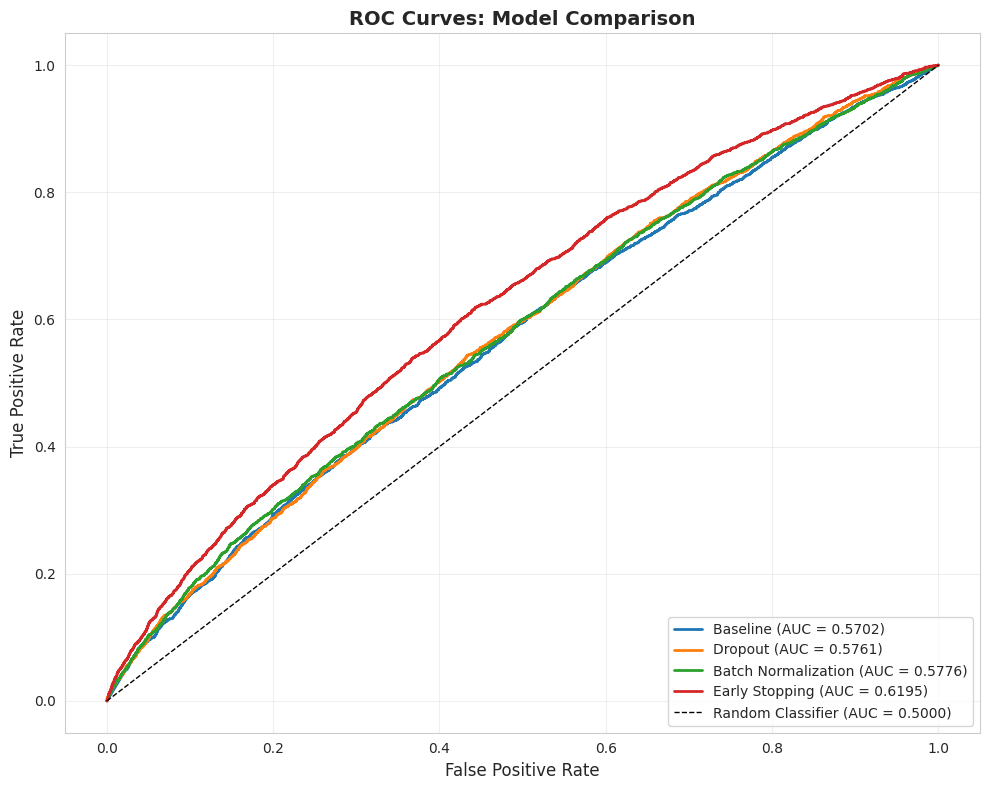

In [42]:
# Calculate ROC curves for all models
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_dropout, tpr_dropout, _ = roc_curve(y_test, y_pred_proba_dropout)
fpr_batchnorm, tpr_batchnorm, _ = roc_curve(y_test, y_pred_proba_batchnorm)
fpr_earlystop, tpr_earlystop, _ = roc_curve(y_test, y_pred_proba_earlystop)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_baseline, tpr_baseline, linewidth=2, label=f'Baseline (AUC = {roc_auc_baseline:.4f})')
plt.plot(fpr_dropout, tpr_dropout, linewidth=2, label=f'Dropout (AUC = {roc_auc_dropout:.4f})')
plt.plot(fpr_batchnorm, tpr_batchnorm, linewidth=2, label=f'Batch Normalization (AUC = {roc_auc_batchnorm:.4f})')
plt.plot(fpr_earlystop, tpr_earlystop, linewidth=2, label=f'Early Stopping (AUC = {roc_auc_earlystop:.4f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Model Selection and Justification

Based on the comparison table and ROC curves, we select the best model for deployment.

In [43]:
# Identify the best model based on ROC AUC Score
best_model_name = models_summary.iloc[0]['Model']
best_roc_auc = models_summary.iloc[0]['ROC AUC Score']

print("Best Model Selection:")
print("="*70)
print(f"Selected Model: {best_model_name}")
print(f"ROC AUC Score: {best_roc_auc:.4f}")
print("\nJustification:")

# Map model names to actual model objects
model_map = {
    'Baseline': baseline_model,
    'Dropout': dropout_model,
    'Batch Normalization': batchnorm_model,
    'Early Stopping': earlystop_model
}

best_model = model_map[best_model_name]

if best_model_name == 'Baseline':
    print("The baseline model performed best, suggesting that the architecture is")
    print("well-suited for the task and additional regularization was not needed.")
elif best_model_name == 'Dropout':
    print("Dropout regularization improved performance by preventing overfitting through")
    print("random neuron deactivation during training, forcing more robust feature learning.")
elif best_model_name == 'Batch Normalization':
    print("Batch Normalization improved performance by normalizing layer inputs, which")
    print("stabilizes training and acts as implicit regularization.")
elif best_model_name == 'Early Stopping':
    print("Early Stopping prevented overfitting by halting training when validation")
    print("performance stopped improving, preserving the best model weights.")

print("\nThis model achieved the highest ROC AUC score, indicating the best ability")
print("to discriminate between readmitted and non-readmitted patients across all")
print("classification thresholds.")
print("="*70)

Best Model Selection:
Selected Model: Early Stopping
ROC AUC Score: 0.6195

Justification:
Early Stopping prevented overfitting by halting training when validation
performance stopped improving, preserving the best model weights.

This model achieved the highest ROC AUC score, indicating the best ability
to discriminate between readmitted and non-readmitted patients across all
classification thresholds.


### Save the Best Model

We save the best performing model to disk for future use in inference and deployment.

In [44]:
# Save the best model
best_model_path = os.path.join(MODELS_DIR, 'best_mlp_model.h5')
best_model.save(best_model_path)

print("Model Saved Successfully:")
print("="*70)
print(f"Model Name: {best_model_name}")
print(f"File Path: {best_model_path}")
print(f"ROC AUC Score: {best_roc_auc:.4f}")
print("\nThis model can now be loaded for making predictions on new patient data.")
print("="*70)

# Verify the model was saved
import os.path
if os.path.exists(best_model_path):
    file_size = os.path.getsize(best_model_path) / (1024 * 1024)  # Convert to MB
    print(f"\n✓ Model file verified: {file_size:.2f} MB")
else:
    print("\n✗ ERROR: Model file not found!")

Model Saved Successfully:
Model Name: Early Stopping
File Path: /home/ghost/workspace/university/machine_learning_and_computer_vision/assessment_main/models/best_mlp_model.h5
ROC AUC Score: 0.6195

This model can now be loaded for making predictions on new patient data.

✓ Model file verified: 3.48 MB


## Summary

### Completed Steps:

1. ✓ Loaded preprocessed data (`3_final_data.npz`) and preprocessor (`preprocessor.joblib`)
2. ✓ Performed edge case checks (GPU availability, data shape validation, class distribution)
3. ✓ Built and trained baseline MLP model (128-64-1 architecture)
4. ✓ Applied three regularization techniques:
   - Dropout (0.3 rate)
   - Batch Normalization
   - Early Stopping (patience=5)
5. ✓ Evaluated all models with classification metrics and ROC curves
6. ✓ Selected best model based on ROC AUC score
7. ✓ Saved best model to `models/best_mlp_model.h5`

### Key Findings:

- All models were evaluated on their ability to predict 30-day hospital readmission
- ROC AUC was used as the primary metric for model selection
- The best model represents an optimal balance between predictive performance and generalization

### Next Steps:

- Use the saved model for inference on new patient data
- Generate final report with consolidated results (Notebook 4)
- Consider further model tuning if performance needs improvement

---

**End of Notebook 3: Model Training and Evaluation**